# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Определение функций и классов

## Определение функций генерации данных и их визуализации

In [2]:
def true_fun(x, a=np.pi, b=0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x:x # line
    x = np.sum([ai * np.power(x, i + 1) for i, ai in enumerate(a)], axis=0)

    return f(x + b)

#---------------------------------
def noises(shape , noise_power):
    return np.random.randn(*shape) *noise_power

#---------------------------------
def dataset(a, b, f=None,  N=250, x_max=1, noise_power=0, random_x=True,  seed=42):
    np.random.seed(seed)

    if random_x:
        x = np.sort(np.random.rand(N)) * x_max
    else:
        x = np.linspace(0, x_max, N)

    y_true = np.array([])

    for f_ in np.append([], f):
        y_true = np.append(y_true, true_fun(x, a, b, f_))

    y_true = y_true.reshape(-1, N).T
    y = y_true + noises(y_true.shape , noise_power)

    return y, y_true, np.atleast_2d(x).T

#---------------------------------
def vis_data(y, y_true,x, title, figsize=(10, 7)):
    fig = plt.figure(figsize=figsize)
    plt.scatter(x[:,0], y, edgecolor='b', label="Зашумленные Данные", s=196, alpha = 0.6)
    plt.scatter(x[:,0], y_true, label="Реальные Данные", s=81, c='g', alpha=0.8)
    plt.grid()
    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    plt.legend(fontsize=12)
    plt.title(title, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12);
    plt.tight_layout()

## Определение функции разделения данных на обучающие и тестовые

In [3]:
def train_test_split(x, y, train_size=None, test_size=None, random_state=42, shuffle=True):
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)

    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<= 1):  train_size = 1 - test_size
        else:  train_size = size - test_size

        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
        
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size <= 1: test_size *= size    
        if test_size > size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val, y_val     = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze()

    return x_train, y_train.squeeze(), x_val, y_val.squeeze()

## Определение функции визуализации обучающих и тестовых данных 

In [4]:
def plot_model_class(x_train, y_train, x_test, x, y, model):
    plt.plot(x_train[:,0], model.predict(x_train), '.', label='Предсказание на x_train', markersize=15)
    plt.plot(x_test[:,0], model.predict(x_test), 'o', label='Предсказание на x_test', markersize=15, alpha=0.8)
    plt.plot(x_train[:,0], y_train, '.', label="Тренировочные данные", linewidth=2, c='r')
    plt.plot(x[:,0], y, '--', label="Истинные Значения", linewidth=4, c='g')
    plt.legend(fontsize=16); plt.grid()
    plt.xlabel('x',fontsize=16)
    plt.ylabel('y',fontsize=16);
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12);

## Определение функций визуализации весов признаков

In [5]:
def vis_weigths(weights):
    numbers = np.arange(0, len(weights))
    tick_labels = ['w' + str(num) for num in numbers]
    cc = [''] * len(numbers)

    for n, val in enumerate(weights):
        if val < 0:
            cc[n] = 'red'
        elif val >= 0:
            cc[n] = 'blue'

    plt.bar(x=numbers, height=weights, color=cc)
    plt.xticks(np.arange(0, len(weights)), tick_labels)
    
#---------------------------------
def weights_vis(B, B0, features_names):
    numbers = np.arange(0, len(features_names) + 1)
    Bs = np.hstack([B0, B])
    tick_labels = ['B' + str(num) for num in numbers]
    cc = [''] * len(numbers)

    for n, val in enumerate(Bs):
        if val < 0:
            cc[n] = 'red'
        elif val >= 0:
            cc[n] = 'blue'
            
    plt.bar(x = numbers, height = Bs, color = cc)
    plt.xticks(np.arange(0, len(features_names) + 1), np.hstack(['b0', features_names]), rotation = 45);

## Описания функции создания полинома из входных данных

In [6]:
def to_polynom(x, order=1, add_bias=False):
    order_range = range(0 if add_bias else 1, order+1, 1)
    x = np.atleast_1d(x)[:]    
    out = np.array([])

    for i in order_range:
        out = np.append(out, np.power(x, i))

    return out.reshape(-1, x.size).T

## Определение класса линейной регрессии

In [7]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self, yhat, y):
        return np.square(yhat - y).sum() / y.size
    
    #---------------------------------
    def grad_step(self, yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size) / np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1 - np.sum(np.square(y - yhat)) / np.sum(np.square(y - np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias, self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size // self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X, y)): 
                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]

    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0, y.size, self.batch_size):
            idx_batch = idxs[i_batch:i_batch + self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize=(12, 6), title=''):
        plt.figure(figsize=figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize=24)
        plt.ylabel('Функция Потерь', fontsize=24)
        plt.title(title, fontsize=24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

## Определение класса L1 регуляризации

In [8]:
class LassoRegression(LinearRegression):
    def __init__(self,
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs,
                         weights = weights,
                         bias    = bias,
                         batch_size   = batch_size,
                         n_batches    = n_batches,
                         random_state = random_state)

        self.l1_penalty = l1_penalty

    #---------------------------------
    def loss(self,yhat, y):
        l1_term = self.l1_penalty * np.sum(np.abs(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term

    #---------------------------------
    def update(self):
        return self.weights - self.lr * (self.grad + np.sign(self.weights) * self.l1_penalty)


## Определение класса L2 регуляризации

In [9]:
class RidgeRegression(LinearRegression):
    def __init__(self,
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):

        super().__init__(learning_rate = learning_rate,
                         epochs = epochs,
                         weights = weights,
                         bias    = bias,
                         batch_size   = batch_size,
                         n_batches    = n_batches,
                         random_state = random_state)

        self.l2_penalty = l2_penalty

    #---------------------------------
    def loss(self,yhat, y):   
        l2_term = (self.l2_penalty / 2) * np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term

    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty * np.mean(self.weights[1:])
        return self.weights - self.lr * (self.grad + l2_term)

# Синтетические данные

## Набор данных №1 (линейная зависимость)

### Генерация и визуализация данных

In [10]:
noise_power = 0.1

y1, y1_true, x1 = dataset(
    a=2,
    b=-1,
    f=None,
    N=100,
    x_max=1,
    noise_power=noise_power,
    seed=42
)

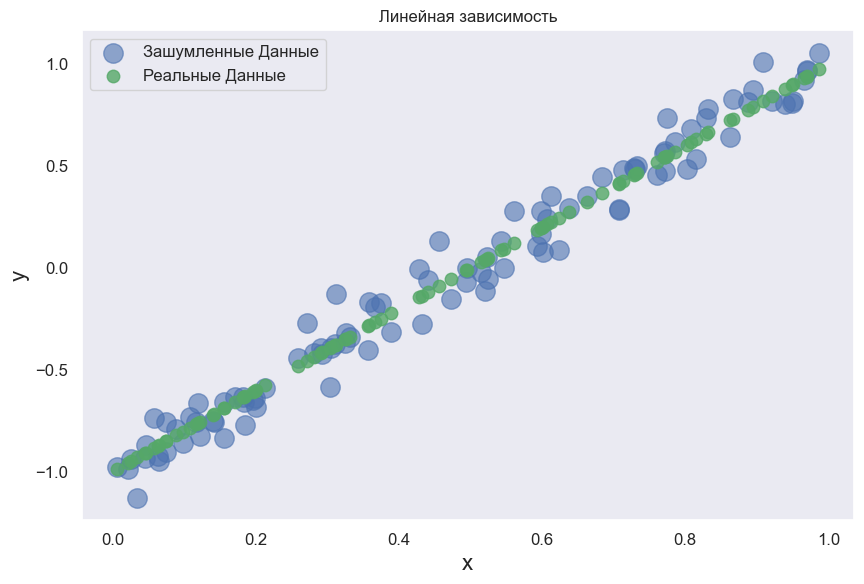

In [11]:
vis_data(y1, y1_true, x1, 'Линейная зависимость', figsize=(8.8, 6))

### Линейная регрессия

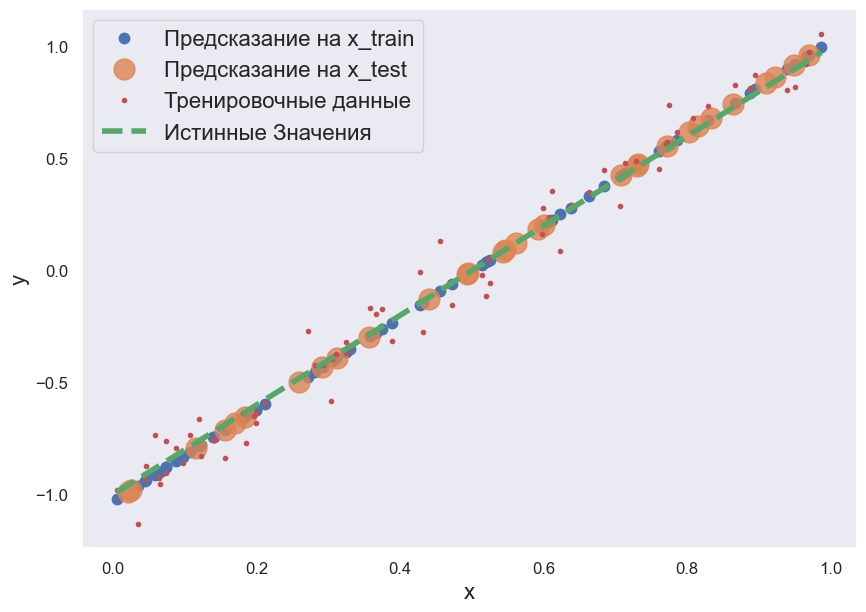

In [12]:
linear_regression = LinearRegression(
    learning_rate=0.1,
    epochs=100,
    batch_size=10,
    n_batches=None
)

x1_train, y1_train, x1_test, y1_test = train_test_split(x1, y1, test_size=0.3)

linear_regression.fit(x1_train, y1_train)

fig  = plt.figure(figsize=(10, 7))
plot_model_class(x1_train, y1_train, x1_test, x1, y1_true, linear_regression)

### Полиноминальная регрессия

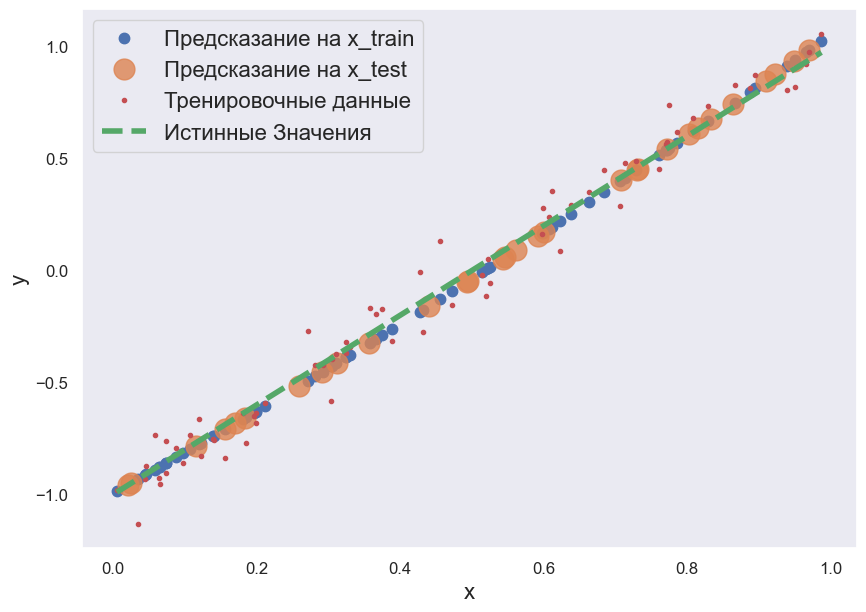

In [13]:
polynomial_regression = LinearRegression(
    learning_rate=0.2,
    epochs=100,
    batch_size=10,
    n_batches=None
)

x1_pol = to_polynom(x1, order=3)
x1_pol_train, y1_pol_train, x1_pol_test, y1_pol_test = train_test_split(x1_pol, y1, test_size=0.3)

polynomial_regression.fit(x1_pol_train, y1_pol_train)

fig  = plt.figure(figsize=(10, 7))
plot_model_class(x1_pol_train, y1_pol_train, x1_pol_test, x1_pol, y1_true, polynomial_regression)

### L1 регуляризация

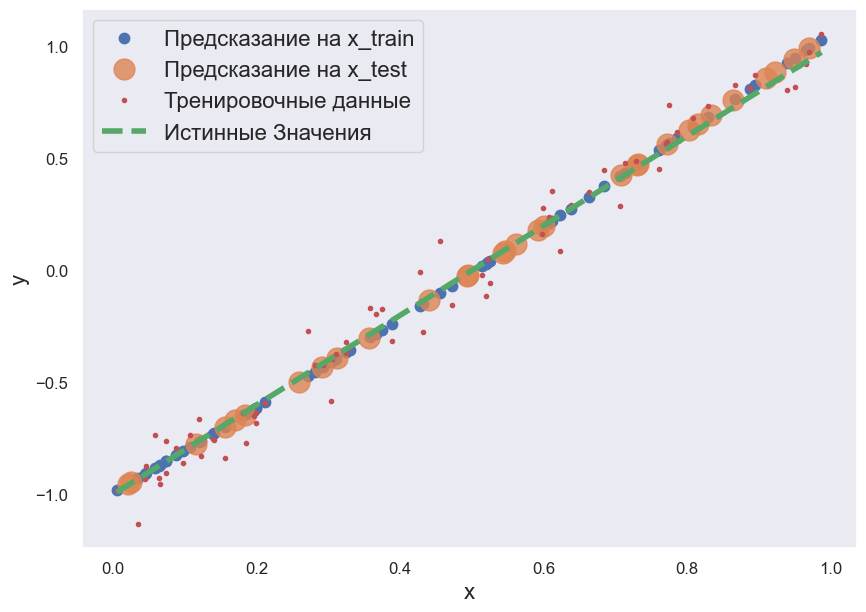

In [14]:
lasso_regression = LassoRegression(
    learning_rate=0.1,
    epochs=300,
    batch_size=10,
    l1_penalty=0.001
)

x1_lasso = to_polynom(x1, order=3)
x1_lasso_train, y1_lasso_train, x1_lasso_test, y1_lasso_test = train_test_split(x1_lasso, y1, test_size=0.3)

lasso_regression.fit(x1_lasso_train, y1_lasso_train)

fig = plt.figure(figsize=(10, 7))
plot_model_class(x1_lasso_train, y1_lasso_train, x1_lasso_test, x1_lasso, y1_true, lasso_regression)

### L2 регуляризация

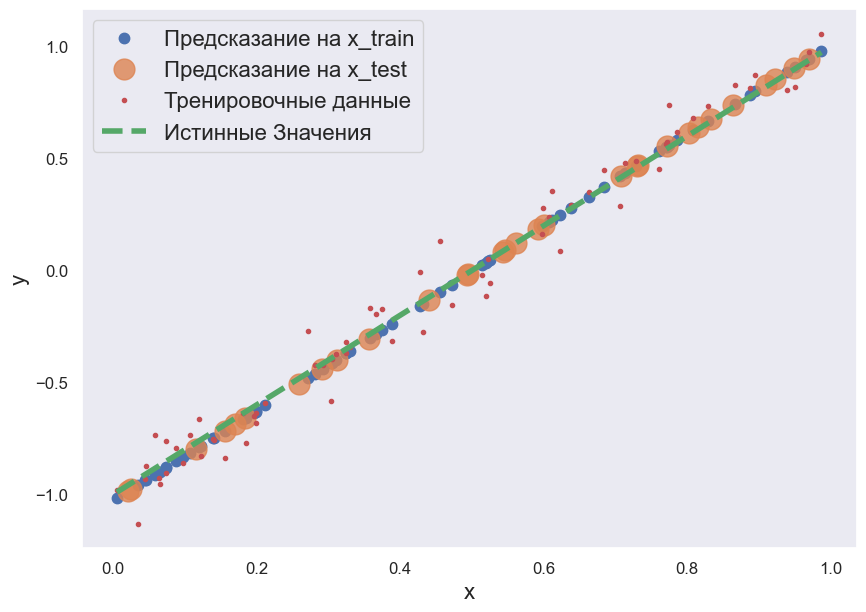

In [15]:
ridge_regression = RidgeRegression(
    learning_rate=0.25,
    epochs=300,
    batch_size=10,
    l2_penalty=0.001
)

x1_ridge = to_polynom(x1, order=3)
x1_ridge_train, y1_ridge_train, x1_ridge_test, y1_ridge_test = train_test_split(x1_ridge, y1, test_size=0.3)

ridge_regression.fit(x1_ridge_train, y1_ridge_train)

fig = plt.figure(figsize=(10, 7))
plot_model_class(x1_ridge_train, y1_ridge_train, x1_ridge_test, x1_ridge, y1_true, ridge_regression)

## Набор данных №2 (полиноминальная зависимость)

### Генерация и визуализация данных

In [16]:
noise_power = 0.1

y2, y2_true, x2 = dataset(
    a=[-2, 3, -1],
    b=2,
    f=None,
    N=100,
    x_max=1,
    noise_power=noise_power,
    seed=42
)

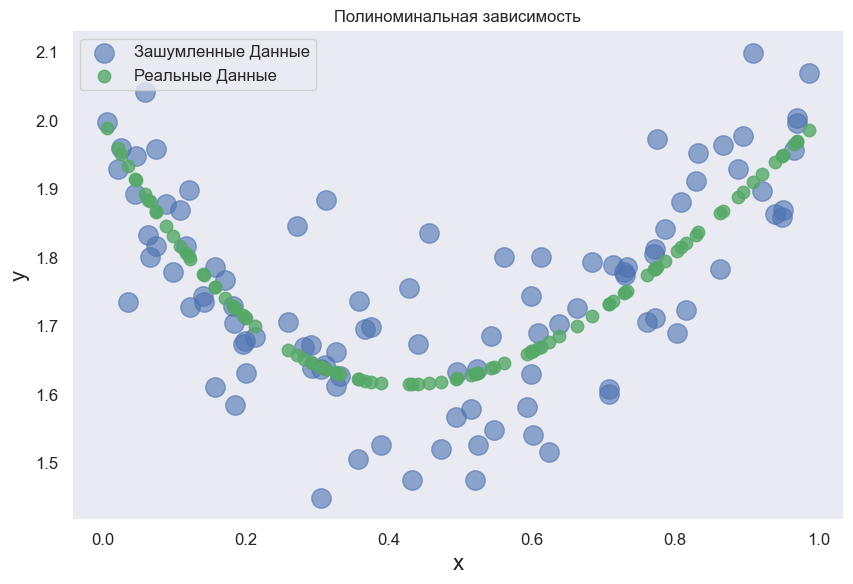

In [17]:
vis_data(y2, y2_true, x2, 'Полиноминальная зависимость', figsize=(8.7, 6))

### Линейная регрессия

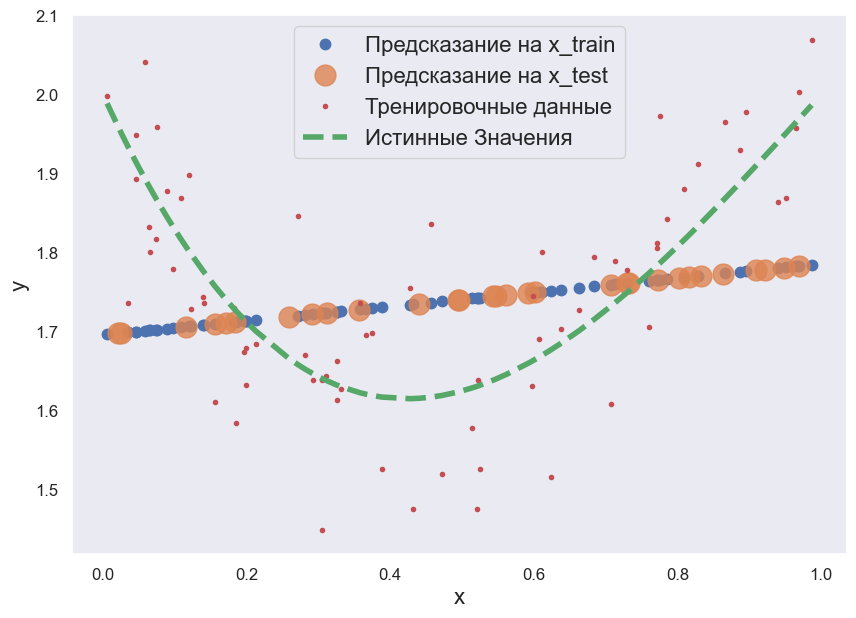

In [18]:
x2_train, y2_train, x2_test, y2_test = train_test_split(x2, y2, test_size=0.3)

linear_regression.fit(x2_train, y2_train)

fig  = plt.figure(figsize=(10, 7))
plot_model_class(x2_train, y2_train, x2_test, x2, y2_true, linear_regression)

### Полиноминальная регрессия

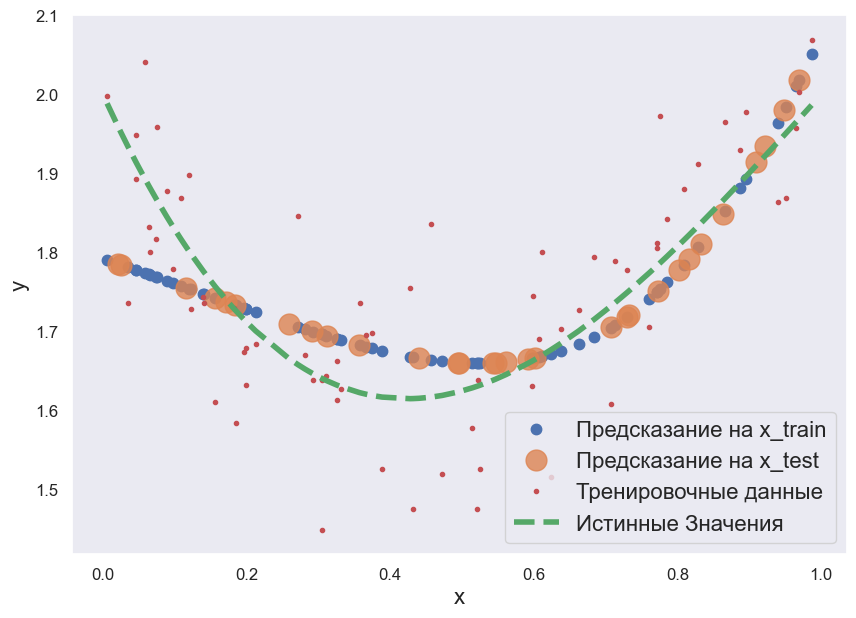

In [19]:
polynomial_regression = LinearRegression(
    learning_rate=0.1,
    epochs=100,
    batch_size=10,
    n_batches=None
)

x2_pol = to_polynom(x2, order=10)
x2_pol_train, y2_pol_train, x2_pol_test, y2_pol_test = train_test_split(x2_pol, y2, test_size=0.3)

polynomial_regression.fit(x2_pol_train, y2_pol_train)

fig  = plt.figure(figsize=(10, 7))
plot_model_class(x2_pol_train, y2_pol_train, x2_pol_test, x2_pol, y2_true, polynomial_regression)

### L1 регуляризация

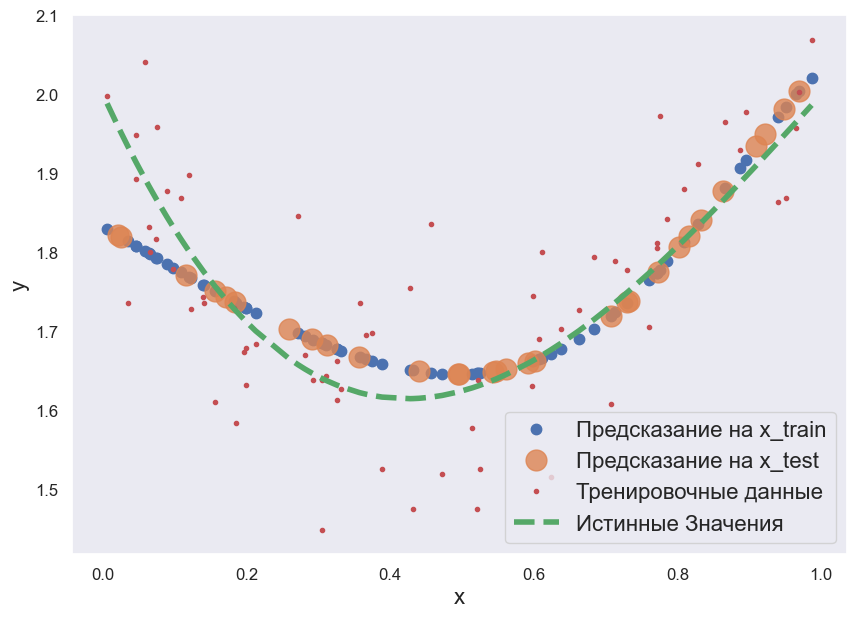

In [20]:
lasso_regression = LassoRegression(
    learning_rate=0.1,
    epochs=300,
    batch_size=10,
    l1_penalty=0.001
)

x2_lasso = to_polynom(x2, order=10)
x2_lasso_train, y2_lasso_train, x2_lasso_test, y2_lasso_test = train_test_split(x2_lasso, y2, test_size=0.3)

lasso_regression.fit(x2_lasso_train, y2_lasso_train)

fig = plt.figure(figsize=(10, 7))
plot_model_class(x2_lasso_train, y2_lasso_train, x2_lasso_test, x2_lasso, y2_true, lasso_regression)

### L2 регуляризация

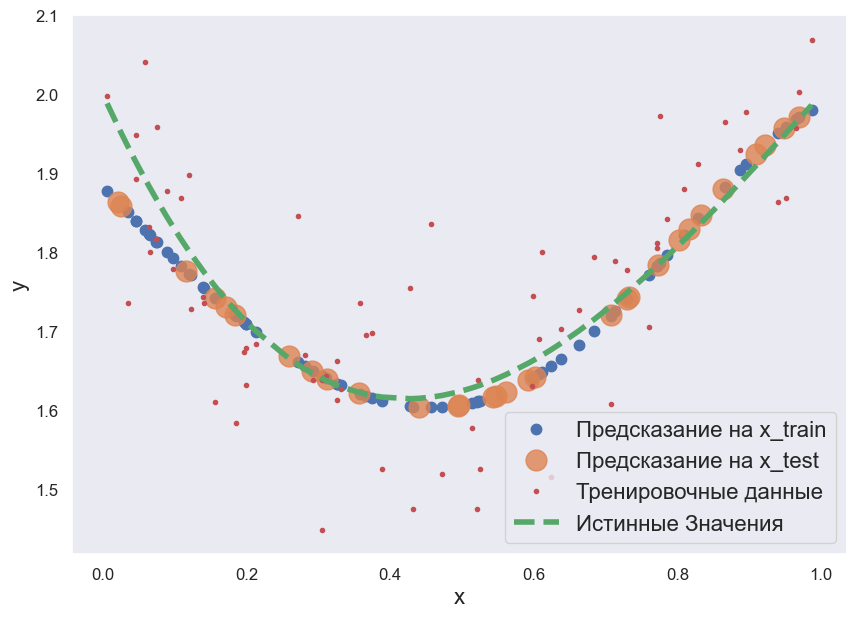

In [21]:
ridge_regression = RidgeRegression(
    learning_rate=0.25,
    epochs=300,
    batch_size=10,
    l2_penalty=0.001
)

x2_ridge = to_polynom(x2, order=7)
x2_ridge_train, y2_ridge_train, x2_ridge_test, y2_ridge_test = train_test_split(x2_ridge, y2, test_size=0.3)

ridge_regression.fit(x2_ridge_train, y2_ridge_train)

fig = plt.figure(figsize=(10, 7))
plot_model_class(x2_ridge_train, y2_ridge_train, x2_ridge_test, x2_ridge, y2_true, ridge_regression)

## Набор данных №3 (гармоническая зависимость)

### Генерация и визуализация данных

In [22]:
noise_power = 0.1

y3, y3_true, x3 = dataset(
    a=-4,
    b=-2,
    f=np.cos,
    N=100,
    x_max=np.pi/2,
    noise_power=noise_power,
    seed=42
)

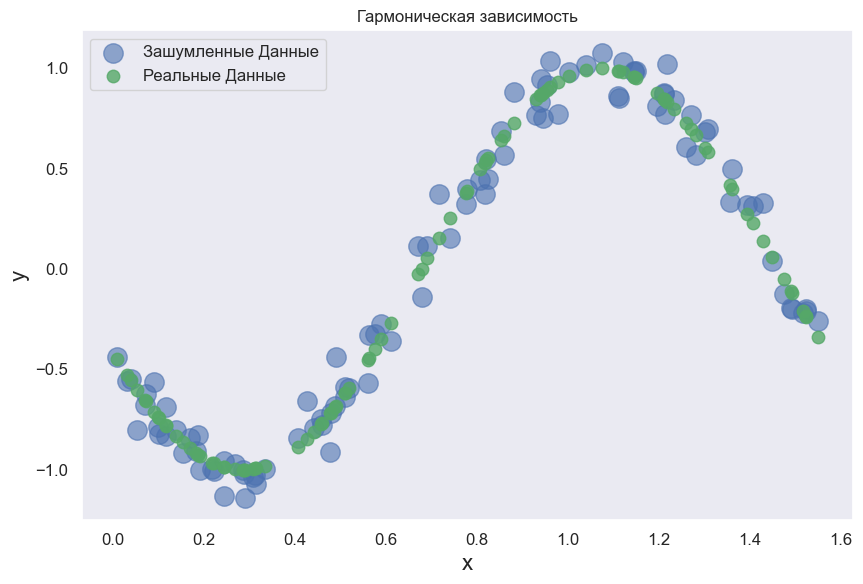

In [23]:
vis_data(y3, y3_true, x3, 'Гармоническая зависимость', figsize=(8.8, 6))

### Линейная регрессия

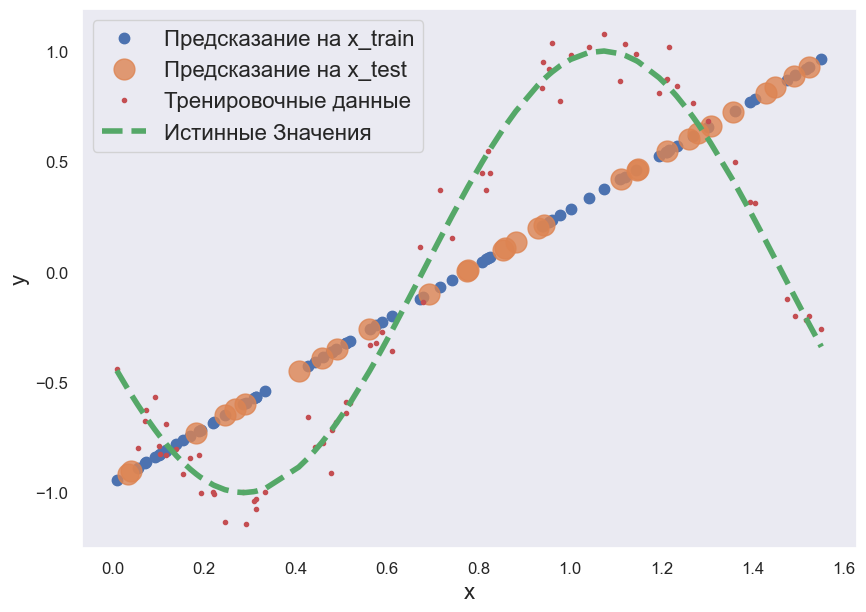

In [24]:
x3_train, y3_train, x3_test, y3_test = train_test_split(x3, y3, test_size=0.3)

linear_regression.fit(x3_train, y3_train)

fig  = plt.figure(figsize=(10, 7))
plot_model_class(x3_train, y3_train, x3_test, x3, y3_true, linear_regression)

### Полиноминальная регрессия

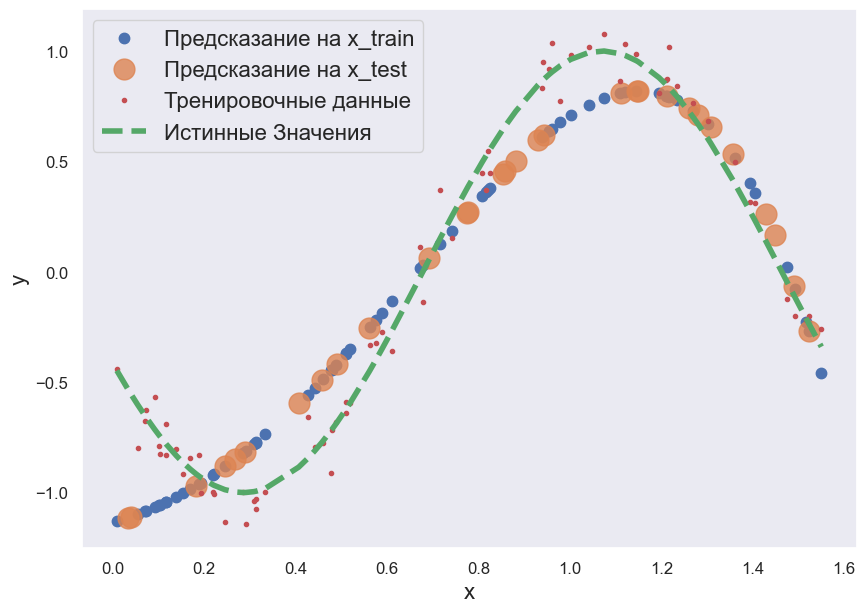

In [25]:
polynomial_regression = LinearRegression(
    learning_rate=0.1,
    epochs=100,
    batch_size=10,
    n_batches=None
)

x3_pol = to_polynom(x3, order=4)
x3_pol_train, y3_pol_train, x3_pol_test, y3_pol_test = train_test_split(x3_pol, y3, test_size=0.3)

polynomial_regression.fit(x3_pol_train, y3_pol_train)

fig  = plt.figure(figsize=(10, 7))
plot_model_class(x3_pol_train, y3_pol_train, x3_pol_test, x3_pol, y3_true, polynomial_regression)

### L1 регуляризация

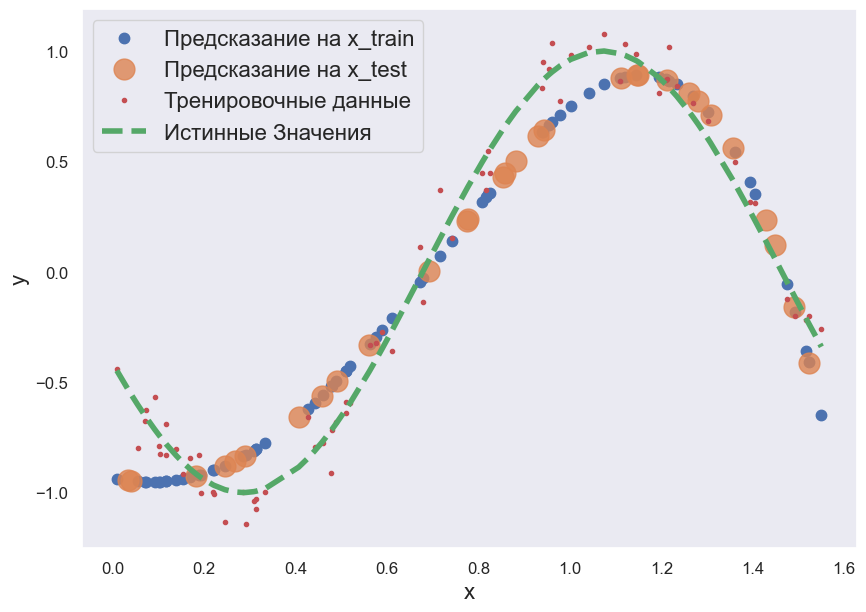

In [26]:
lasso_regression = LassoRegression(
    learning_rate=0.1,
    epochs=300,
    batch_size=10,
    l1_penalty=0.001
)

x3_lasso = to_polynom(x3, order=4)
x3_lasso_train, y3_lasso_train, x3_lasso_test, y3_lasso_test = train_test_split(x3_lasso, y3, test_size=0.3)

lasso_regression.fit(x3_lasso_train, y3_lasso_train)

fig = plt.figure(figsize=(10, 7))
plot_model_class(x3_lasso_train, y3_lasso_train, x3_lasso_test, x3_lasso, y3_true, lasso_regression)

### L2 регуляризация

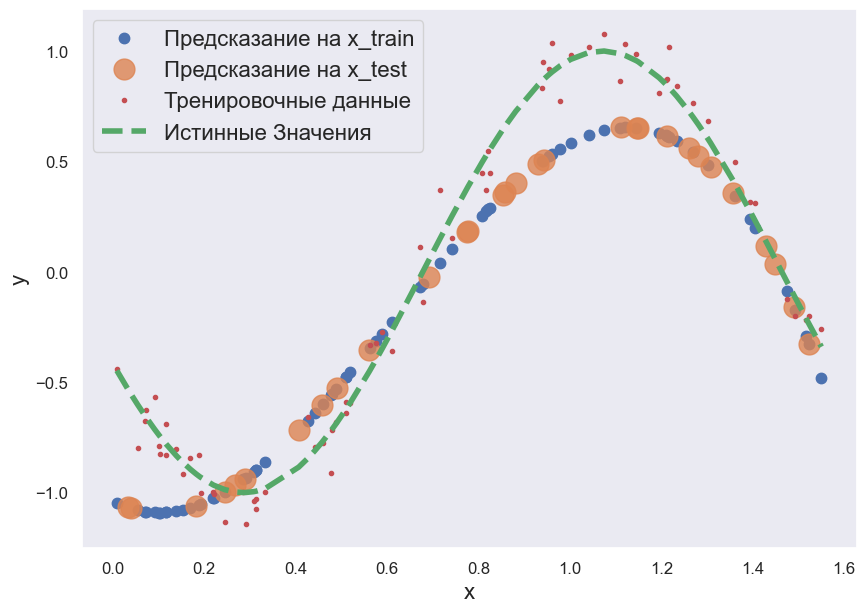

In [27]:
ridge_regression = RidgeRegression(
    learning_rate=0.25,
    epochs=300,
    batch_size=10,
    l2_penalty=0.001
)

x3_ridge = to_polynom(x3, order=3)
x3_ridge_train, y3_ridge_train, x3_ridge_test, y3_ridge_test = train_test_split(x3_ridge, y3, test_size=0.3)

ridge_regression.fit(x3_ridge_train, y3_ridge_train)

fig = plt.figure(figsize=(10, 7))
plot_model_class(x3_ridge_train, y3_ridge_train, x3_ridge_test, x3_ridge, y3_true, ridge_regression)

## Набор данных №4 (экспоненциальная зависимость)

### Генерация и визуализация данных

In [28]:
noise_power = 0.1

y4, y4_true, x4 = dataset(
    a=1,
    b=-2,
    f=np.exp,
    N=100,
    x_max=1,
    noise_power=noise_power,
    seed=42
)

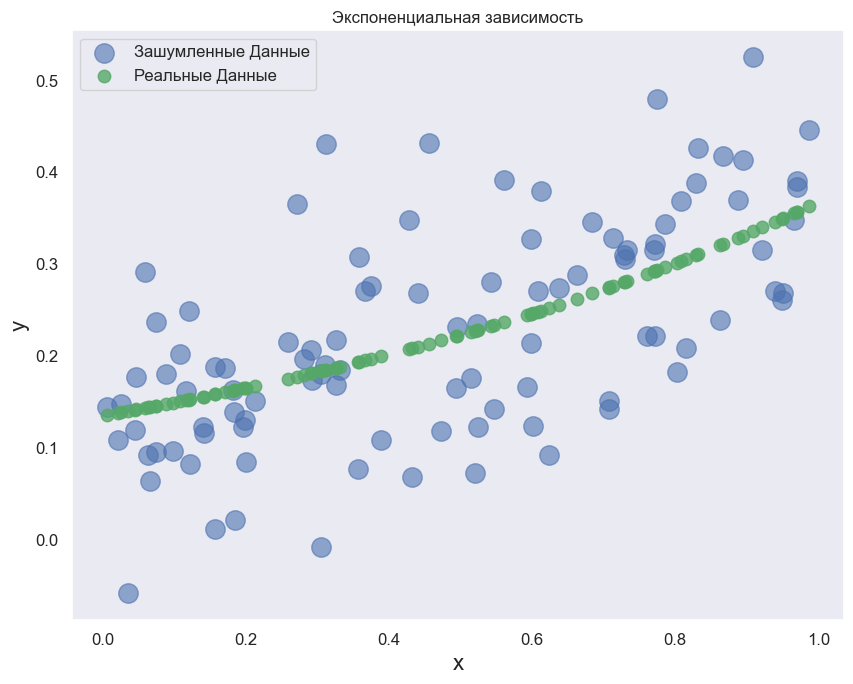

In [29]:
vis_data(y4, y4_true, x4, 'Экспоненциальная зависимость', figsize=(8.7, 7))

### Линейная регрессия

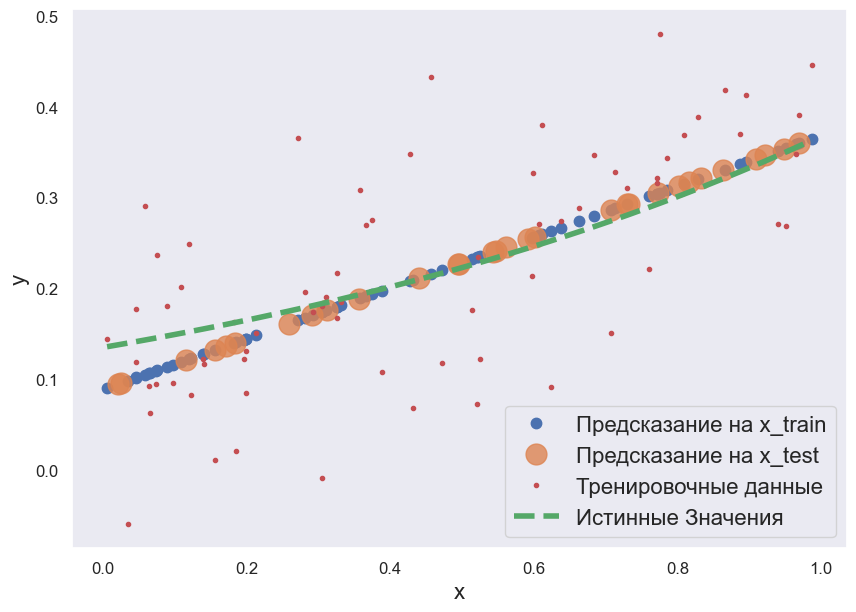

In [30]:
x4_train, y4_train, x4_test, y4_test = train_test_split(x4, y4, test_size=0.3,)

linear_regression.fit(x4_train, y4_train)

fig  = plt.figure(figsize=(10, 7))
plot_model_class(x4_train, y4_train, x4_test, x4, y4_true, linear_regression)

### Полиноминальная регрессия

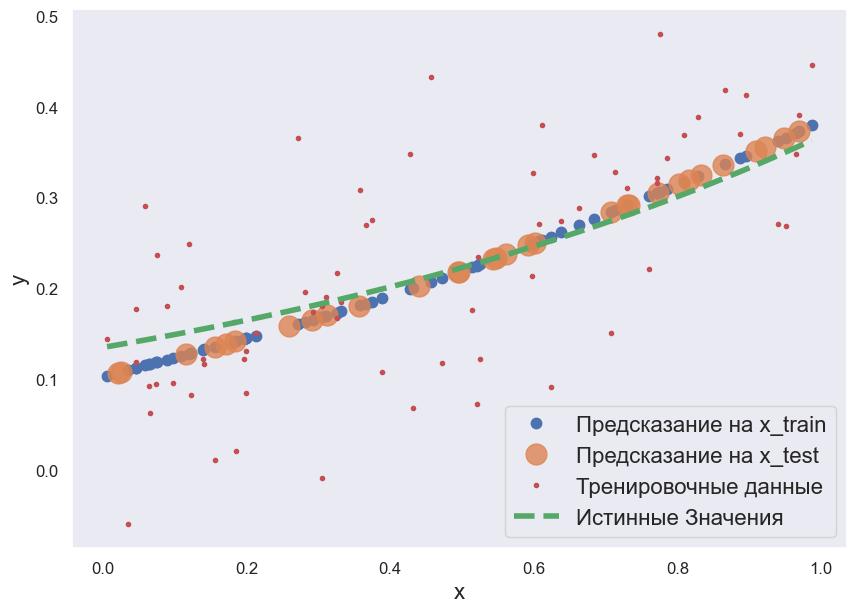

In [31]:
polynomial_regression = LinearRegression(
    learning_rate=0.1,
    epochs=100,
    batch_size=10,
    n_batches=None
)

x4_pol = to_polynom(x4, order=7)
x4_pol_train, y4_pol_train, x4_pol_test, y4_pol_test = train_test_split(x4_pol, y4, test_size=0.3)

polynomial_regression.fit(x4_pol_train, y4_pol_train)

fig  = plt.figure(figsize=(10, 7))
plot_model_class(x4_pol_train, y4_pol_train, x4_pol_test, x4_pol, y4_true, polynomial_regression)

### L1 регуляризация

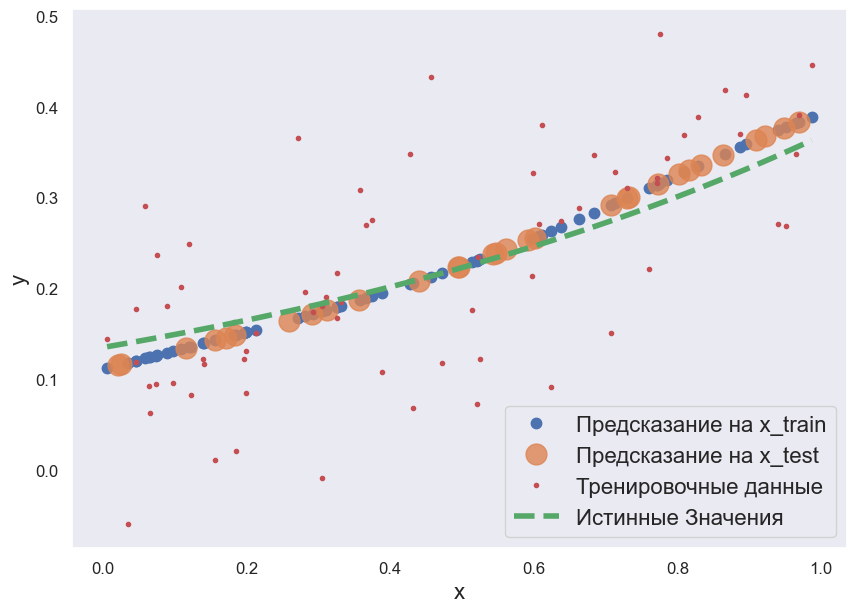

In [32]:
lasso_regression = LassoRegression(
    learning_rate=0.1,
    epochs=300,
    batch_size=10,
    l1_penalty=0.001
)

x4_lasso = to_polynom(x4, order=7)
x4_lasso_train, y4_lasso_train, x4_lasso_test, y4_lasso_test = train_test_split(x4_lasso, y4, test_size=0.3)

lasso_regression.fit(x4_lasso_train, y4_lasso_train)

fig = plt.figure(figsize=(10, 7))
plot_model_class(x4_lasso_train, y4_lasso_train, x4_lasso_test, x4_lasso, y4_true, lasso_regression)

### L2 регуляризация

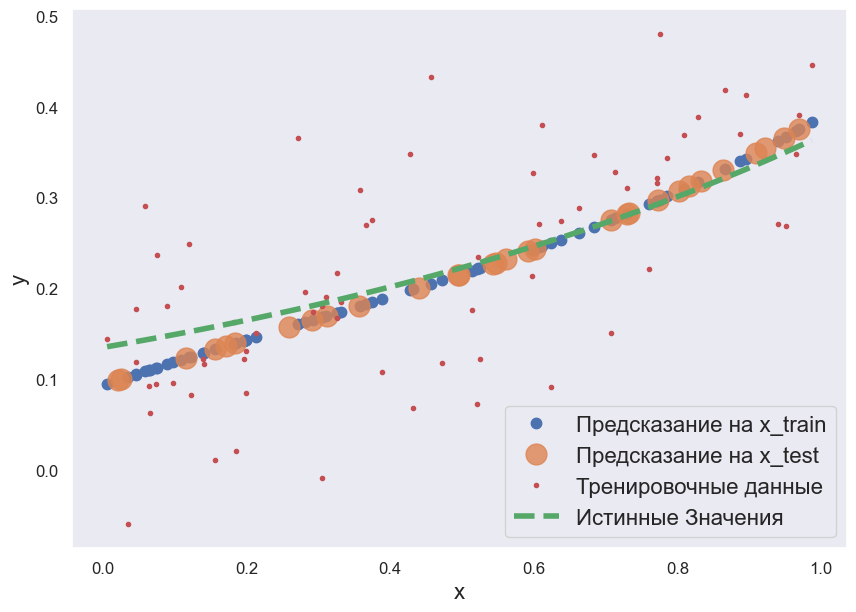

In [33]:
ridge_regression = RidgeRegression(
    learning_rate=0.25,
    epochs=300,
    batch_size=10,
    l2_penalty=0.001
)

x4_ridge = to_polynom(x4, order=3)
x4_ridge_train, y4_ridge_train, x4_ridge_test, y4_ridge_test = train_test_split(x4_ridge, y4, test_size=0.3)

ridge_regression.fit(x4_ridge_train, y4_ridge_train)

fig = plt.figure(figsize=(10, 7))
plot_model_class(x4_ridge_train, y4_ridge_train, x4_ridge_test, x4_ridge, y4_true, ridge_regression)

### L1 регуляризация

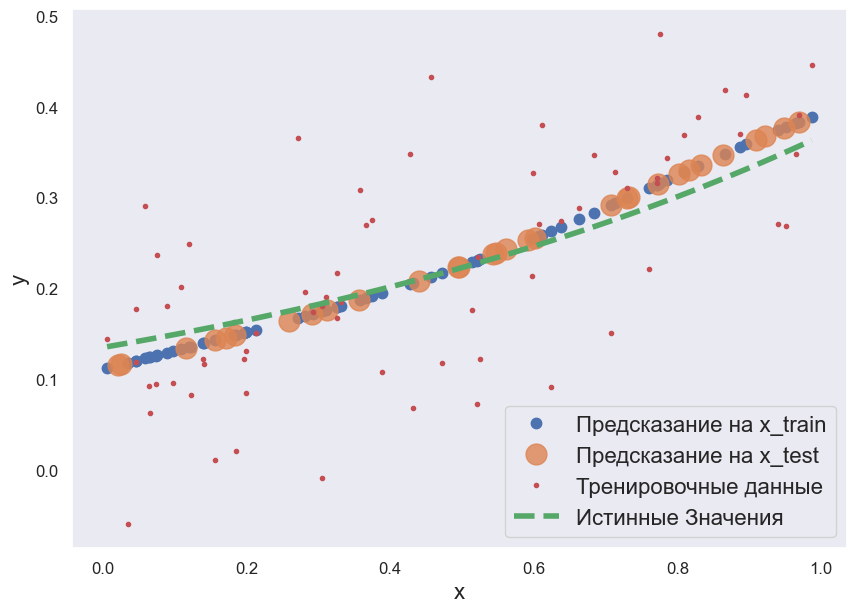

In [34]:
lasso_regression = LassoRegression(
    learning_rate=0.1,
    epochs=300,
    batch_size=10,
    l1_penalty = 0.001
)

lasso_regression.fit(x4_pol_train, y4_pol_train)

fig  = plt.figure(figsize=(10, 7))
plot_model_class(x4_pol_train, y4_pol_train, x4_pol_test, x4_pol, y4_true, lasso_regression)

# Набора данных Cars Moldova

## Импорт библиотек

In [35]:
# Импортируем LinearRegression из scikit-learn с псевдонимом LR,
# чтобы не переопределеить существует класс с таким же именем
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

## Загрузка данных

In [36]:
car_df = pd.read_csv('data/cars_moldova_data.csv', delimiter=',')

In [37]:
car_df.sample(5)

,Make,Model,Year,Style,Distance,Engine_capacity,Fuel_type,Transmission,Price,Age,Km_year,Km_year_quantile,Make_model,Make_model_mean_price,Make_model_median_price
5750,Dacia,Logan Mcv,2008,Universal,387300.0,1400.0,Metan/Propan,Manual,2750.0,14,27664.285714,Большой пробег,Dacia Logan Mcv,4813.797909,4650.0
13236,Mercedes,CLS Class,2005,Coupe,208702.0,3500.0,Metan/Propan,Automatic,10999.0,17,12276.588235,Средний пробег,Mercedes CLS Class,17878.264706,18950.0
24913,Renault,Megane,2002,Universal,350000.0,1870.0,Diesel,Manual,1100.0,20,17500.000000,Большой пробег,Renault Megane,5670.967120,5648.5
29976,Volkswagen,Polo,2010,Hatchback,85000.0,1200.0,Petrol,Manual,3700.0,12,7083.333333,Небольшой пробег,Volkswagen Polo,4600.038251,3900.0
7593,Volkswagen,Multivan,2014,Minivan,111898.0,2000.0,Diesel,Automatic,31500.0,8,13987.250000,Средний пробег,Rare & High,18246.533333,17800.0


## Работа с данными

### Выделим числовые и категориальные столбцы

In [38]:
def split_column_by_types(df):
    category_columns = []
    number_columns = []

    for column in df.columns:
        if df[column].dtypes == object or df[column].dtypes == 'category':
            category_columns += [column]
        else:
            number_columns += [column]
    
    return category_columns, number_columns

In [39]:
category_columns, number_columns = split_column_by_types(car_df)

print(category_columns)
print(number_columns)

['Make', 'Model', 'Style', 'Fuel_type', 'Transmission', 'Km_year_quantile', 'Make_model']
['Year', 'Distance', 'Engine_capacity', 'Price', 'Age', 'Km_year', 'Make_model_mean_price', 'Make_model_median_price']


## Линейная регрессия (числовые признаки)

### Создадим набор данных только с числовыми признаками

In [40]:
car_df_number = car_df[number_columns].copy()
car_df_number.head(5)

,Year,Distance,Engine_capacity,Price,Age,Km_year,Make_model_mean_price,Make_model_median_price
0,2011,195000.0,1800.0,7750.0,11,17727.272727,8276.508621,7900.0
1,2014,135000.0,1500.0,8550.0,8,16875.000000,7177.654912,6999.0
2,2012,110000.0,1500.0,6550.0,10,11000.000000,4598.121951,5099.0
3,2006,200000.0,1600.0,4100.0,16,12500.000000,4488.550877,4300.0
4,2000,300000.0,2200.0,3490.0,22,13636.363636,8236.543333,7500.0


### Нормализация данных

In [41]:
car_df_number_norm = car_df_number.copy()

x_min = car_df_number_norm[number_columns].min()
x_max = car_df_number_norm[number_columns].max()

car_df_number_norm[number_columns] = (car_df_number_norm[number_columns] - x_min) / (x_max - x_min)

### Стандартизация данных

In [42]:
car_df_number_scale = car_df_number.copy()

x_mean = car_df_number_scale[number_columns].mean()
x_std = car_df_number_scale[number_columns].std()

car_df_number_scale[number_columns] = (car_df_number_scale[number_columns] - x_mean) / x_std

### Логарифмирование и стандартизация данных

In [43]:
car_df_number_log = car_df_number.copy()

car_df_number_log[number_columns] = np.log(car_df_number_log[number_columns])

x_mean = car_df_number_log[number_columns].mean()
x_std = car_df_number_log[number_columns].std()

car_df_number_log[number_columns] = (car_df_number_log[number_columns] - x_mean) / x_std

### Выделим значения признаков и целевой признак стоимости автомобиля

In [44]:
X_norm, y_norm_true = car_df_number_norm.drop(columns=['Price']).values, car_df_number_norm['Price'].values
X_scale, y_scale_true = car_df_number_scale.drop(columns=['Price']).values, car_df_number_scale['Price'].values
X_log, y_log_true = car_df_number_log.drop(columns=['Price']).values, car_df_number_log['Price'].values

### L2 регуляризация (нормализованные данные)

In [45]:
sclearn_ridge = Ridge(
    alpha=200,
    max_iter=10000
)

X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(
    X_norm,
    y_norm_true,
    test_size=0.3,
    random_state=42
)

sclearn_ridge.fit(X_norm_train, y_norm_train)
y_norm_predict = sclearn_ridge.predict(X_norm_test)

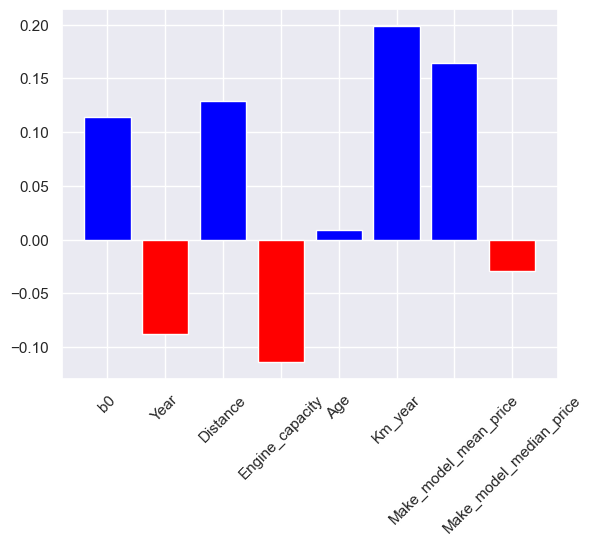

In [46]:
weights_vis(sclearn_ridge.intercept_, sclearn_ridge.coef_, car_df_number_norm.drop(columns=['Price']).columns)

In [47]:
scoring = {'R2': 'r2', '-MSE': 'neg_mean_squared_error', '-MAE': 'neg_mean_absolute_error', 'Max': 'max_error'}

scores = cross_validate(
    sclearn_ridge,
    X_norm_train,
    y_norm_train,
    scoring=scoring,
    cv=ShuffleSplit(n_splits=5, random_state=42)
)

display(pd.DataFrame(scores))

,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,0.002999,0.001002,0.637286,-0.003296,-0.034632,-0.573688
1,0.004001,0.000999,0.560121,-0.004194,-0.035848,-0.942321
2,0.003000,0.000999,0.601836,-0.003739,-0.035479,-0.575281
3,0.003001,0.000000,0.602355,-0.003687,-0.035711,-0.629080
4,0.003999,0.001001,0.592103,-0.003752,-0.035077,-0.738042


In [48]:
print('MSE: %.4f' % mse(y_norm_test, y_norm_predict))
print('RMSE: %.4f' % mse(y_norm_test, y_norm_predict, squared=False))
print('R2 : %.4f' %  r2_score(y_norm_test, y_norm_predict))

MSE: 0.0034
RMSE: 0.0584
R2 : 0.5930


### L2 регуляризация (стандартизированные данные)

In [49]:
sclearn_ridge = Ridge(
    alpha=200,
    max_iter=10000
)

X_scale_train, X_scale_test, y_scale_train, y_scale_test = train_test_split(
    X_scale,
    y_scale_true,
    test_size=0.3,
    random_state=42
)

sclearn_ridge.fit(X_scale_train, y_scale_train)
y_scale_predict = sclearn_ridge.predict(X_scale_test)

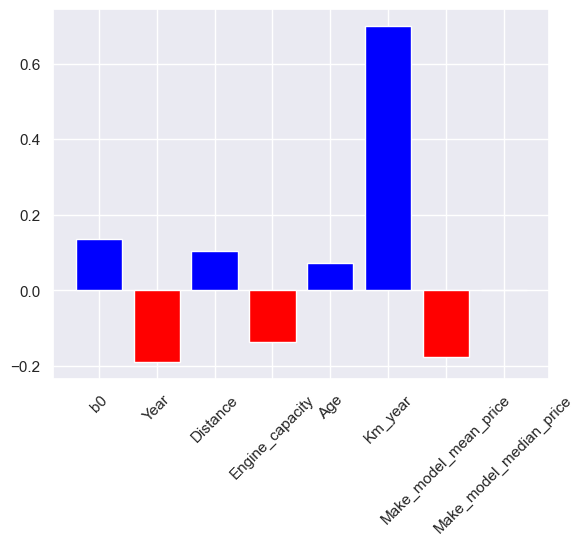

In [50]:
weights_vis(sclearn_ridge.intercept_, sclearn_ridge.coef_, car_df_number_scale.drop(columns=['Price']).columns)

In [51]:
scoring = {'R2': 'r2', '-MSE': 'neg_mean_squared_error', '-MAE': 'neg_mean_absolute_error', 'Max': 'max_error'}

scores = cross_validate(
    sclearn_ridge,
    X_scale_train,
    y_scale_train,
    scoring=scoring,
    cv=ShuffleSplit(n_splits=5, random_state=42)
)

display(pd.DataFrame(scores))

,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,0.004002,0.001000,0.703211,-0.299665,-0.338502,-5.649005
1,0.003000,0.000999,0.623519,-0.398759,-0.354947,-9.995115
2,0.003000,0.000999,0.669017,-0.345331,-0.348910,-5.157183
3,0.002999,0.001001,0.666400,-0.343631,-0.351157,-6.706825
4,0.003002,0.000999,0.652038,-0.355623,-0.346003,-6.721712


In [52]:
print('MSE: %.4f' % mse(y_scale_test, y_scale_predict))
print('RMSE: %.4f' % mse(y_scale_test, y_scale_predict, squared=False))
print('R2 : %.4f' %  r2_score(y_scale_test, y_scale_predict))

MSE: 0.3213
RMSE: 0.5669
R2 : 0.6553


### L2 регуляризация (логарифмирование и стандартизация данных)

In [53]:
sclearn_ridge = Ridge(
    alpha=200,
    max_iter=10000
)

X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(
    X_log,
    y_log_true,
    test_size=0.3,
    random_state=42
)

sclearn_ridge.fit(X_log_train, y_log_train)
y_log_predict = sclearn_ridge.predict(X_log_test)

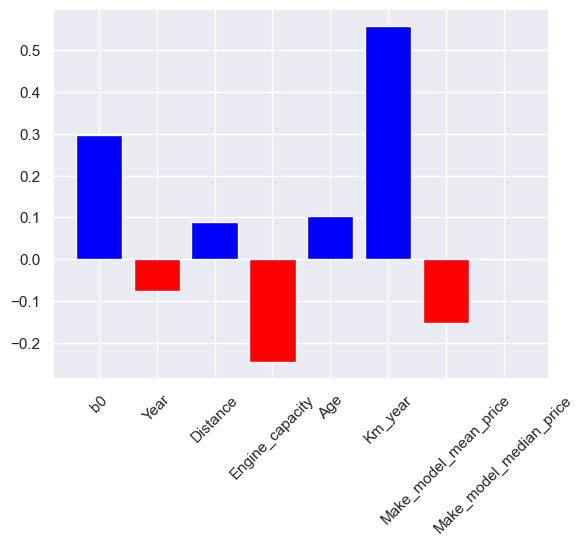

In [54]:
weights_vis(sclearn_ridge.intercept_, sclearn_ridge.coef_, car_df_number_norm.drop(columns=['Price']).columns)

In [55]:
scoring = {'R2': 'r2', '-MSE': 'neg_mean_squared_error', '-MAE': 'neg_mean_absolute_error', 'Max': 'max_error'}

scores = cross_validate(
    sclearn_ridge,
    X_log_train,
    y_log_train,
    scoring=scoring,
    cv=ShuffleSplit(n_splits=5, random_state=42)
)

display(pd.DataFrame(scores))

,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,0.004001,0.000999,0.785273,-0.217623,-0.326637,-2.904889
1,0.003001,0.001000,0.790169,-0.219664,-0.328780,-3.295245
2,0.003002,0.000998,0.777111,-0.225165,-0.321821,-3.677773
3,0.003003,0.000999,0.767821,-0.241017,-0.334470,-3.448620
4,0.003000,0.001002,0.794301,-0.197292,-0.315238,-3.330734


In [56]:
print('MSE: %.4f' % mse(y_log_test, y_log_predict))
print('RMSE: %.4f' % mse(y_log_test, y_log_predict, squared=False))
print('R2 : %.4f' %  r2_score(y_log_test, y_log_predict))

MSE: 0.2213
RMSE: 0.4704
R2 : 0.7769


## Линейная регрессия (числовые и категориальные признаки)

In [57]:
car_df_all = car_df.copy()
car_df_all.head(5)

,Make,Model,Year,Style,Distance,Engine_capacity,Fuel_type,Transmission,Price,Age,Km_year,Km_year_quantile,Make_model,Make_model_mean_price,Make_model_median_price
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,11,17727.272727,Большой пробег,Toyota Prius,8276.508621,7900.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,8,16875.000000,Средний пробег,Renault Grand Scenic,7177.654912,6999.0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0,10,11000.000000,Небольшой пробег,Renault Laguna,4598.121951,5099.0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,16,12500.000000,Средний пробег,Opel Astra,4488.550877,4300.0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,22,13636.363636,Средний пробег,Mercedes Vito,8236.543333,7500.0


### Логарифмирование и стандартизация данных

In [58]:
car_df_all[number_columns] = np.log(car_df_all[number_columns])

x_mean = car_df_all[number_columns].mean()
x_std = car_df_all[number_columns].std()

car_df_all[number_columns] = (car_df_all[number_columns] - x_mean) / x_std

### Унитарное кодирование

In [59]:
car_df_all = pd.get_dummies(car_df_all)

### L2 регуляризация (логарифмирование и стандартизация данных + унитарное кодирование)

In [60]:
X_all, y_all_true = car_df_all.drop(columns=['Price']).values, car_df_number_norm['Price'].values

In [61]:
sclearn_ridge = Ridge(
    alpha=200,
    max_iter=10000
)

X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(
    X_all,
    y_all_true,
    test_size=0.3,
    random_state=42
)

sclearn_ridge.fit(X_all_train, y_all_train)
y_all_predict = sclearn_ridge.predict(X_all_test)

In [62]:
scoring = {'R2': 'r2', '-MSE': 'neg_mean_squared_error', '-MAE': 'neg_mean_absolute_error', 'Max': 'max_error'}

scores = cross_validate(
    sclearn_ridge,
    X_all_train,
    y_all_train,
    scoring=scoring,
    cv=ShuffleSplit(n_splits=5, random_state=42)
)

display(pd.DataFrame(scores))

,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,0.593022,0.004975,0.726797,-0.002483,-0.028943,-0.501058
1,0.579027,0.003975,0.682568,-0.003026,-0.029700,-0.927644
2,0.580024,0.004976,0.718853,-0.002640,-0.029147,-0.531974
3,0.569026,0.004974,0.732805,-0.002477,-0.028666,-0.595387
4,0.583000,0.004002,0.700342,-0.002757,-0.029160,-0.595185


In [63]:
print('MSE: %.4f' % mse(y_all_test, y_all_predict))
print('RMSE: %.4f' % mse(y_all_test, y_all_predict, squared=False))
print('R2 : %.4f' %  r2_score(y_all_test, y_all_predict))

MSE: 0.0025
RMSE: 0.0502
R2 : 0.7002
